In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import math
from sklearn.metrics import r2_score

In [2]:
z=557
l=33.80

In [3]:
EnamMksJr=pd.read_excel(r'EnamMksJr.xlsx')

In [4]:
def E(T):
    return 0.6108*np.exp((17.27*T)/(T+237.3))
def u2(vitesse):
    return vitesse*(4.87/(math.log(67.8*2 - 5.42)))
def ea(etmin,HR_max,etmax,HR_min):
    return (etmin*(HR_max / 100) + etmax * (HR_min / 100))/2
def ra(J):
    delta=0.409*np.sin(2*np.pi*J/365-1.39) 
    Gcs=0.0820
    phi=l*np.pi/180
    dr=1+0.033*np.cos(2*np.pi*J/365)
    ws=np.arccos(-np.tan(phi)*np.tan(delta))
    return 24*60/np.pi*Gcs*dr*(ws*np.sin(phi)*np.sin(delta)+np.cos(phi)*np.cos(delta)*np.sin(ws))

**Hargreaves Samani**

In [5]:
def Hargreaves_Samani(Tmean,Tmax,Tmin,J):
    Ra=ra(J)
    return 0.0023*Ra*(Tmean+17.8)*(Tmax-Tmin)**0.5

In [6]:
EtHargreaves=[]
for i in range (0,len(EnamMksJr)):
             EtHargreaves.append(Hargreaves_Samani(EnamMksJr['Température moy'].iloc[i],EnamMksJr['Température max'].iloc[i],EnamMksJr['Température min'].iloc[i],EnamMksJr['Date/heure'].iloc[i]))

Text(0, 0.5, 'ET [mm d-1]')

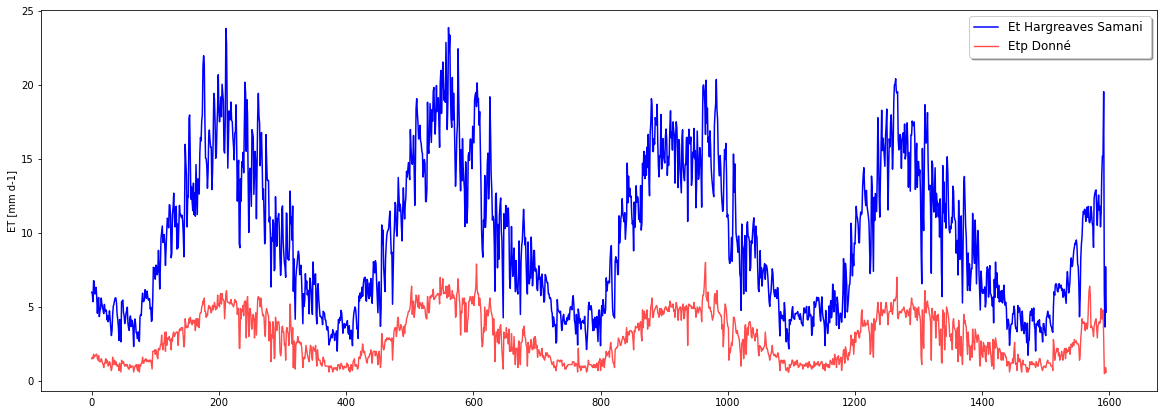

In [7]:
plt.rcParams["figure.figsize"] = (20,7)

fig, ax = plt.subplots()
ax.plot(EtHargreaves,label='Et Hargreaves Samani ',c='blue')
ax.plot(EnamMksJr['ETP quotidien [mm]'],label='Etp Donné',c='red',linewidth=1.4,alpha=0.7)

legend = ax.legend(loc='upper right', shadow=True, fontsize=12)
ax.set_ylabel('ET [mm d-1]')

**score de Hargreaves samani**

In [8]:
r2_score(EtHargreaves,EnamMksJr['ETP quotidien [mm]'])

-1.3459443293173905

**Equation de romanenko**

In [9]:
def Romanenko(T,Rh):
    return 0.00006*((25+T)**2)*(100-Rh)

In [10]:
EtRomaninko=[]
for i in range (0,len(EnamMksJr)):
     EtRomaninko.append(Romanenko(EnamMksJr['Température moy'].iloc[i],EnamMksJr['Humidité moy'].iloc[i]))

Text(0, 0.5, 'ET [mm d-1]')

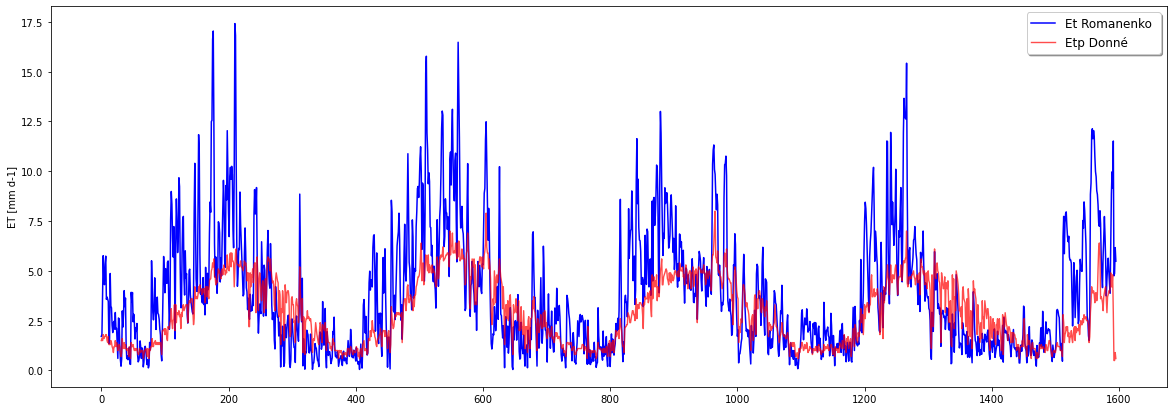

In [11]:
plt.rcParams["figure.figsize"] = (20,7)

fig, ax = plt.subplots()
ax.plot(EtRomaninko,label='Et Romanenko ',c='blue')
ax.plot(EnamMksJr['ETP quotidien [mm]'],label='Etp Donné',c='red',linewidth=1.4,alpha=0.7)

legend = ax.legend(loc='upper right', shadow=True, fontsize=12)
ax.set_ylabel('ET [mm d-1]')

**score Romanenko**

In [12]:
r2_score(EtRomaninko,EnamMksJr['ETP quotidien [mm]'])

0.40495101686466795

**Jensen-Haise**

In [13]:
def Jensen_Haise(T,Rs):
    Rs=Rs*86400/10**6
    return 0.408*Rs*(0.0252*T+0.078)

In [14]:
Etjen=[]
for i in range (0,len(EnamMksJr)):
     Etjen.append(Jensen_Haise(EnamMksJr['Température moy'].iloc[i],EnamMksJr['Rayonnement solaire moy'].iloc[i]))

Text(0, 0.5, 'ET [mm d-1]')

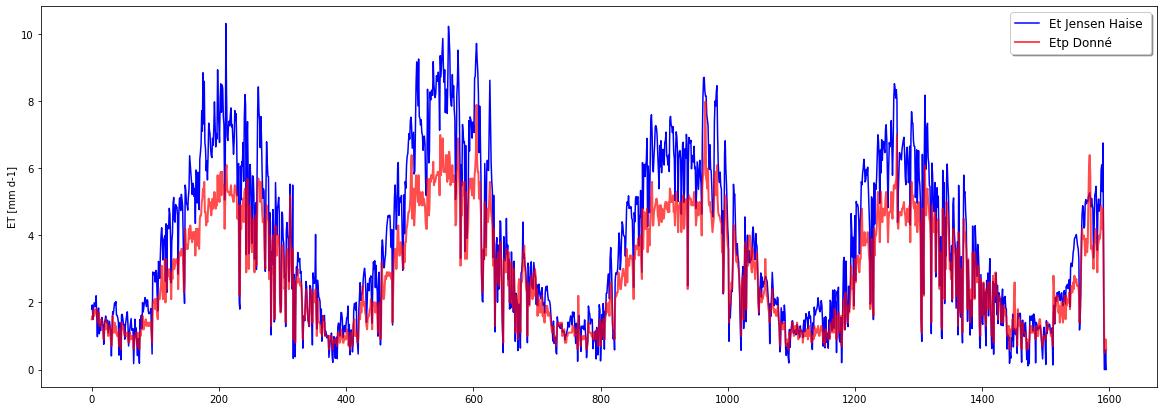

In [15]:
plt.rcParams["figure.figsize"] = (20,7)

fig, ax = plt.subplots()
ax.plot(Etjen,label='Et Jensen Haise ',c='blue')
ax.plot(EnamMksJr['ETP quotidien [mm]'],label='Etp Donné',c='red',linewidth=2,alpha=0.7)

legend = ax.legend(loc='upper right', shadow=True, fontsize=12)
ax.set_ylabel('ET [mm d-1]')

**score Jensen-Haise**

In [16]:
r2_score(Etjen,EnamMksJr['ETP quotidien [mm]'])

0.7574050442838649

**FAO-56 PM**

In [17]:
def Fao(T_max,T_min,HR_max,HR_min,Rs,vitesse,J):
    Rs=Rs *86400/10**6
    U2=u2(vitesse)
    P=101.3*(((293-0.0065*z)/293)**(5.26))
    gamma=0.000665 * P
    sigma=4.903*(10**(-9))
    Tmoy=(T_max+T_min)/2
    Delta= (4098*E(Tmoy))/((Tmoy + 237.3)**2)
    
    #calcul de es
    etmin=E(T_min)
    etmax=E(T_max)
    es=(etmax+etmin)/2
    # ea
    Ea=ea(etmin,HR_max,etmax,HR_min)
    #Ra
    Ra=ra(J)
    #calcul de rso
    Rso=(0.75+2*547.6*10**(-5))*Ra
    #calcul de Rns
    Rns=0.77*Rs
    #calcul de Rnl
    Rnl=sigma*((T_max+273.16)**4+(T_min+273.16)**4)/2*(0.34-0.14*np.sqrt(Ea))*(1.35*Rs/Rso-0.35)
    #calcul de Rn
    Rn=Rns-Rnl
    #calcul de l'ET0 
    Rng=0.408*Rn

    DT = Delta/(Delta+gamma*(1+0.34*U2))
    PT = gamma/(Delta+gamma*(1+0.34*U2))
    TT=(900/(Tmoy+273))*U2
    ETrad = DT*Rng
    ETwind = PT*TT*(es - Ea)
    et0=ETrad+ETwind
    return et0

In [18]:
etp=[]
for i in range(0,len(EnamMksJr)):
    etp.append(Fao(EnamMksJr["Température max"][i],EnamMksJr["Température min"][i],EnamMksJr["Humidité max"][i],EnamMksJr["Humidité min"][i],EnamMksJr["Rayonnement solaire moy"][i],EnamMksJr["Vitesse du vent  moy"][i],EnamMksJr["Date/heure"][i]))


Text(0, 0.5, 'ET [mm d-1]')

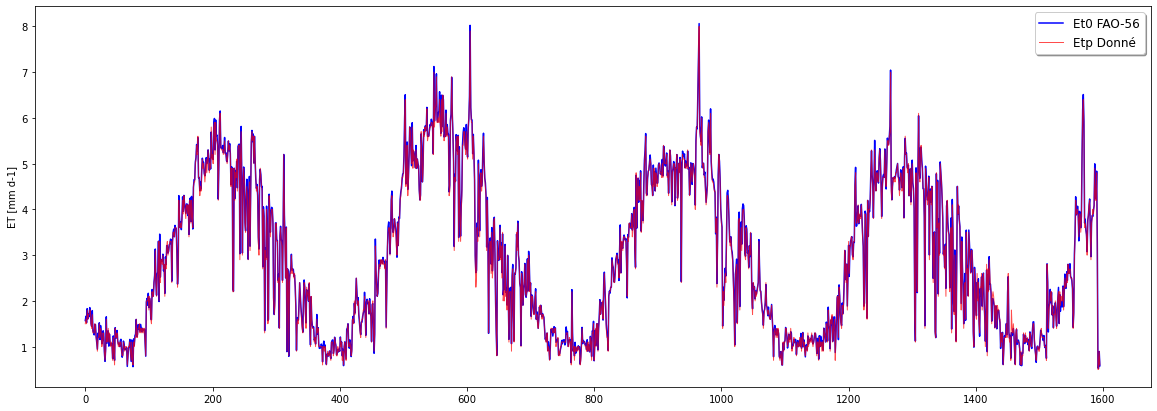

In [19]:
plt.rcParams["figure.figsize"] = (20,7)

fig, ax = plt.subplots()
ax.plot(etp,label='Et0 FAO-56',c='blue')
ax.plot(EnamMksJr["ETP quotidien [mm]"],label='Etp Donné',c='red',linewidth=1,alpha=0.7)

legend = ax.legend(loc='upper right', shadow=True, fontsize=12)
ax.set_ylabel('ET [mm d-1]')

In [20]:
r2_score(etp,EnamMksJr['ETP quotidien [mm]'])

0.9983962874882265

**ASCE**

necessite des données horriares

In [21]:
EnsamMksHr= pd.read_excel(r'EnsamHorraire.xlsx')

In [22]:
def Asce(T_max,T_min,HR_max,HR_min,Rs,vitesse,J):
    Rs=Rs *86400/10**6
    U2=u2(vitesse)
    P=101.3*(((293-0.0065*z)/293)**(5.26))
    gamma=0.000665 * P
    sigma=4.903*(10**(-9))
    Tmoy=(T_max+T_min)/2
    Delta= (4098*E(Tmoy))/((Tmoy + 237.3)**2)
    
    #calcul de es
    etmin=E(T_min)
    etmax=E(T_max)
    es=(etmax+etmin)/2
    # ea
    Ea=ea(etmin,HR_max,etmax,HR_min)
    #Ra
    Ra=ra(J)
    #calcul de rso
    Rso=(0.75+2*547.6*10**(-5))*Ra
    #calcul de Rns
    Rns=0.77*Rs
    #calcul de Rnl
    Rnl=sigma*((T_max+273.16)**4+(T_min+273.16)**4)/2*(0.34-0.14*np.sqrt(Ea))*(1.35*Rs/Rso-0.35)
    #calcul de Rn
    Rn=Rns-Rnl
    #calcul de l'ET0 
    Rng=0.408*Rn
    if(Rn<0): 
        Cd=0.96
    else:
        Cd=0.24
    DT = Delta/(Delta+gamma*(1+Cd*U2))
    PT = gamma/(Delta+gamma*(1+Cd*U2))
    TT=(37/(Tmoy+273))*U2
    ETrad = DT*Rng
    ETwind = PT*TT*(es - Ea)
    et0=ETrad+ETwind
    return et0

In [23]:
EnsamMksHr['ET Horraire']=0
for i in EnsamMksHr.index:
    EnsamMksHr['ET Horraire'][i]=Asce(EnsamMksHr["Température max"][i],EnsamMksHr["Température min"][i],EnsamMksHr["Humidité max"][i],EnsamMksHr["Humidité min"][i],EnsamMksHr["Radiation Solaire moy"][i],EnsamMksHr["Vitesse du vent moy"][i],EnsamMksHr["Date/heure"][i])

C:\Users\PC\AppData\Local\Temp/ipykernel_8356/3239971850.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  EnsamMksHr['ET Horraire'][i]=Asce(EnsamMksHr["Température max"][i],EnsamMksHr["Température min"][i],EnsamMksHr["Humidité max"][i],EnsamMksHr["Humidité min"][i],EnsamMksHr["Radiation Solaire moy"][i],EnsamMksHr["Vitesse du vent moy"][i],EnsamMksHr["Date/heure"][i])


In [24]:
Jour=EnsamMksHr["Date/heure"][0]
EnsamMksHr['ET Daily calculé']=np.nan
temp=[]
case=0
for i in EnsamMksHr.index:
    
    if (EnsamMksHr["Date/heure"][i]==Jour):
        temp.append(EnsamMksHr["ET Horraire"][i])
    elif(EnsamMksHr["Date/heure"][i]!=Jour):
        Etdaily=sum(temp)/len(temp)
        EnsamMksHr['ET Daily calculé'][case]=Etdaily
        Jour=EnsamMksHr["Date/heure"][i]
        temp=[]
        temp.append(EnsamMksHr["ET Horraire"][i])
        case=i-1
    if i == EnsamMksHr.index[-1] :
        Etdaily=sum(temp)/len(temp)
        EnsamMksHr['ET Daily calculé'][case]=Etdaily

C:\Users\PC\AppData\Local\Temp/ipykernel_8356/1927246578.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  EnsamMksHr['ET Daily calculé'][case]=Etdaily
C:\Users\PC\AppData\Local\Temp/ipykernel_8356/1927246578.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  EnsamMksHr['ET Daily calculé'][case]=Etdaily


In [25]:
index = EnsamMksHr['ETP quotidien'].index[EnsamMksHr['ETP quotidien'].apply(np.isnan)]
EnsamMksHr_index=EnsamMksHr.index.values.tolist()
nan_index=[EnsamMksHr_index.index(i) for i in index]
EnsamMksHr.drop(nan_index, axis=0, inplace=True)
EnsamMksHr.reset_index(drop=True, inplace=True)

Text(0, 0.5, 'ET [mm d-1]')

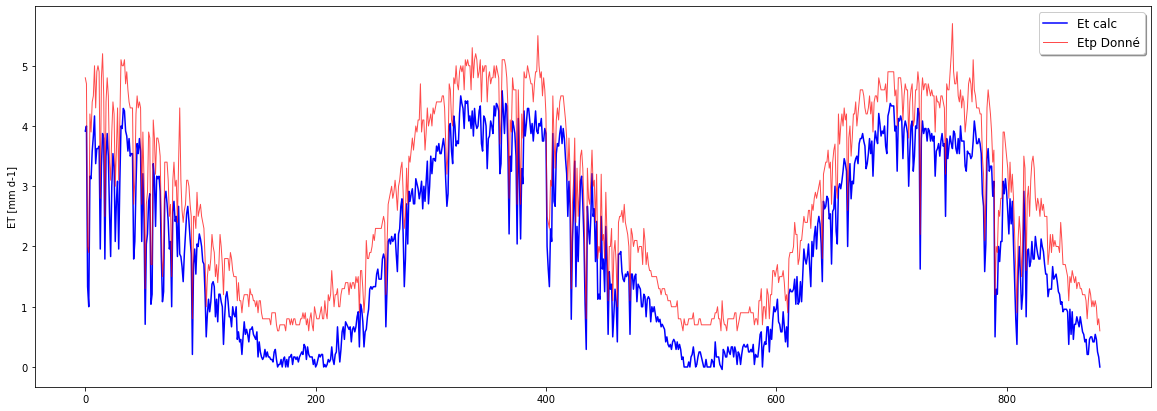

In [26]:
plt.rcParams["figure.figsize"] = (20,7)

fig, ax = plt.subplots()
ax.plot( EnsamMksHr['ET Daily calculé'],label='Et calc ',c='blue')
ax.plot( EnsamMksHr['ETP quotidien'],label='Etp Donné',c='red',linewidth=1,alpha=0.7)

legend = ax.legend(loc='upper right', shadow=True, fontsize=12)
ax.set_ylabel('ET [mm d-1]')

**Score Asce**

In [27]:
r2_score(EnsamMksHr['ET Daily calculé'],EnsamMksHr['ETP quotidien'])

0.715125596504598